In [ ]:
!pip install networkx==2.6.3

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
# load packages needed
import os
import numpy as np
import pandas as pd
import networkx as nx
import scipy.stats as sp
import matplotlib.pyplot as plt
import math
import copy
import datetime
import powerlaw
import scipy
from scipy.special import factorial
import re

In [14]:
# get file names
cwd = os.getcwd() # get current working directory
file_folder = f'{cwd}/data/USD/' # speficy the folder containing original network files
file_list = os.listdir(file_folder)
file_list = sorted(file_list,
                        key =  lambda x: -os.stat(file_folder + x).st_size) # sort in descending order by file size

# extract token names from files names
tickers = []
for name in file_list:
    m = re.search('-([A-Z]*)_price', name)
    if m == None:
        continue
    tickers.append(m.group(1))

# instantiate a list of stable coins
sc_list = ['USDT', 'USD Coin', 'USDC', 'Binance USD', 'BUSD', 'TerraUSD',
        'UST', 'Dai', 'DAI', 'TrueUSD', 'TUSD', 'Pax Dollar', 'USDP',
        'Reserve Rights', 'RSR', 'Neutrino USD', 'USDN', 'Fei USD',
        'FEI', 'HUSD', 'HUSD', 'Frax', 'FRAX', 'Liquity USD', 'LUSD',
        'Tribe', 'TRIBE', 'Gemini Dollar', 'GUSD', 'XSGD', 'XSGD',
        'USDX [Kava]', 'USDX', 'Celo Dollar', 'CUSD', 'Vai', 'VAI',
        'STASIS EURO', 'EURS', 'sUSD', 'SUSD', 'Steem Dollars', 'SBD',
        'Qcash', 'QC', 'DigixDAO', 'DGD', 'mStable USD', 'MUSD',
        'Reserve', 'RSV', 'USDK', 'USDK', 'Origin Dollar', 'OUSD',
        'Rupiah Token', 'IDRT', 'bitCNY', 'BITCNY', 'Digix Gold Token',
        'DGX', 'Xaurum', 'XAUR', 'EOSDT', 'EOSDT', 'CryptoFranc', 'XCHF',
        'NuBits', 'USNBT', 'Stably USD', 'USDS', 'Italian Lira', 'ITL',
        'USDP Stablecoin', 'USDP', 'Tether EURt', 'EURT', 'BRCP TOKEN',
        'BRCP', 'BiLira', 'TRYB', 'Alchemix USD', 'ALUSD', 'Celo Euro',
        'CEUR', 'Meter Stable', 'MTR', 'xDollar Stablecoin', 'XUSD',
        'Zytara dollar', 'ZUSD', 'Coffin Finance', 'COFFIN', 'Parallel',
        'PAR', 'USD Bancor', 'USDB', 'Midas Dollar Share', 'MDS',
        'Midas Dollar', 'MDO', 'Karatgold Coin', 'KBC',
        'Diamond Platform Token', 'DPT', 'USDQ', 'USDQ', '1irstGold',
        '1GOLD', 'Binance VND', 'BVND', 'USDFreeLiquidity', 'USDFL',
        'bitUSD', 'BITUSD', 'bitGold', 'BITGOLD', 'bitEUR', 'BITEUR',
        'HelloGold', 'HGT', 'Constant', 'CONST', 'xEURO', 'XEUR',
        'Binance GBP Stable Coin', 'BGBP', 'EURBASE', 'EBASE',
        'Binance KRW', 'BKRW', 'USDL', 'USDL', 'Unbound Ethereum',
        'UETH', 'USDEX', 'USDEX', 'Fluity USD', 'FLUSD',
        'dHEDGE Stablecoin Yield', 'DUSD', 'PAX']
sc_list = [sc.upper() for sc in sc_list] # convert to uppercase
# compare if any overlap
sc_tickers = set(tickers) & set(sc_list)
print (f'Number of stable coin in the list is {len(sc_tickers)}')

# remove files from the file list and ticker list that are stable coins
for f in file_list:
    for t in sc_tickers:
        if t in f.upper():
            file_list.remove(f)
            tickers.remove(t)

sc_tickers = set(tickers) & set(sc_list)
print (f'Number of stable coin in the list is {len(sc_tickers)}')

Number of stable coin in the list is 1
Number of stable coin in the list is 0


In [17]:
file_name = file_list[0]

time_list = [] # for common time list of tokens seen so far, 
                # eg. time_list[5] is the list of time covered by all first 6 tokens
time_len_list = [] # length of common time list
time_ind_list = [] # for time list of individual tokens,
                    # eg. time_ind_list[5] is the list of time covered by all the 6-th tokens
time_ind_len_list = [] # length of individual time list

for file_name in file_list:
    if file_name[-3:] != 'csv': # sanity check for .csv files
        continue
    
    print (f'{file_name} loaded\n---------------')
    df = pd.read_csv(file_folder + file_name, skiprows=2, header=10) # read csv file
#     df = pd.read_csv(file_folder + file_name).dropna() # read csv file & drop lines with na


    # from here on only consider the the 5-th row ([4]), close price
    nonzero_mask = list(df.iloc[:, 4] != 0) # a boolean mask of non-zero elements
    idx = np.array(list(range(len(nonzero_mask)))) @ nonzero_mask # find the row idx of the first non-zero element
    df = df[df.iloc[:, 4] != 0] # starting from the first non-zero element

    # check the time idx covered
    df_t = list(df.iloc[:, 0])
    time_ind_list.append(df_t)
    time_ind_len_list.append(len(df_t))
    if len(time_list) < 1:
        temp_t = df_t # initialize the list
    else:
        temp_t = set(time_list[-1]) & set(df_t) # compare the time span of current df w/ existing ones, take the intersection
        temp_t = sorted(list(temp_t)) # parse set to sorted list
    time_list.append(temp_t) # add common time series list to 'time_list'
    time_len_list.append(len(temp_t)) # add common time series length to 'time_len_list'

USD-BTC_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-ETH_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-XRP_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-XLM_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-DOGE_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-LTC_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-ADA_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-ZRX_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-LINK_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-MKR_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-ALGO_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-DASH_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-XTZ_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-ETC_price_hist_2020-01-01_2021-11-25.csv loaded
---------------
USD-EOS_price_hist_2020-01-01_2021-11-25.csv

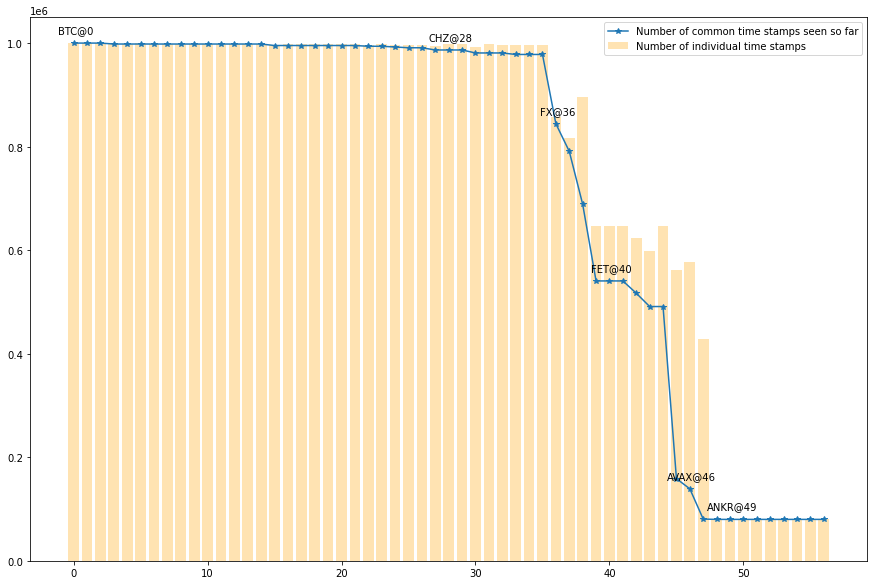

In [18]:
# plot the length of time covered
fig, ax = plt.subplots(1, 1, figsize = (15, 10))
ax.plot(time_len_list, '*-', label = 'Number of common time stamps seen so far')
ax.bar(list(range(len(time_list))), time_ind_len_list, alpha = 0.3, color = 'orange', label = 'Number of individual time stamps')
ax.legend()
big_drop_idx = [0, 28, 36, 40, 46, 49]
for idx in big_drop_idx:
    label = tickers[idx] + '@' + str(idx)
    ax.annotate(label, # this is the text
                     (idx,time_len_list[idx]), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(2,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center



## Question to reflect on: do we want to narrow the scope of crypto currencies to top 28, 36 or 40 to get better data coverage?

Taking 50 for now.

The gap between time stamps is 60 and BTC covers the most time stamps, 1e6. So I assume it's minute data, over the period from 2020-Jan-01 to 2021-Nov-25, which is equivalently 694 days ≈ 1e6 / (60 * 24).
**By picking top 50 tokens (in terms of time stamps covered), we can only take 8e4 time stamps, or roughly 55 days, which might be a problem.**

In [19]:
num_tokens = 50 # number of selected tokens

In [22]:
# take first num_tokens tokens for now
t = time_list[num_tokens - 1]
# check if t is continuous w/o gap
print (f'Whether time stamps are continuous: {max(np.diff(t)) == min(np.diff(t))}')

80064
Whether time stamps are continuous: True


In [26]:
price_m = [] # price matrix for close prices
num_tokens = 1

raw_data = {}

for i in range(num_tokens):
    file_name = file_list[i]
    
    # load .csv file
    df = pd.read_csv(file_folder + file_name) #, skiprows = 2, header=10) # read csv file
    print(df)
    
    # given the list of time stamps, generate a boolean mask to access rows in each df
    upper_bound = (df.iloc[:, 0] <= max(t)).to_numpy() # boolean mask of upper bound of time stamps
    lower_bound = (df.iloc[:, 0] >= min(t)).to_numpy() # boolean mask of lower bound of time stamps
    t_mask = lower_bound & upper_bound # bitwise and operation to boolean mask of time stamps
    
    # append selected close prices to price matrix
    price_m.append(df[t_mask].iloc[:, 4].to_numpy()) # append close prices of selected time stamps to price matrix

USD-BTC_price_hist_2020-01-01_2021-11-25.csv
               time exchange fsym tsym     close      high       low  \
0        1577836800   CCCAGG  BTC  USD   7197.87   7198.83    7177.4   
1        1577836860   CCCAGG  BTC  USD   7196.69   7198.64   7195.68   
2        1577836920   CCCAGG  BTC  USD   7195.84    7197.1   7195.78   
3        1577836980   CCCAGG  BTC  USD   7197.82   7197.82   7195.68   
4        1577837040   CCCAGG  BTC  USD   7195.11   7197.99   7195.11   
...             ...      ...  ...  ...       ...       ...       ...   
1000795  1637884500   CCCAGG  BTC  USD  58954.97  58973.23  58944.38   
1000796  1637884560   CCCAGG  BTC  USD  58950.13  58962.93   58948.0   
1000797  1637884620   CCCAGG  BTC  USD  58951.21  58951.21  58940.59   
1000798  1637884680   CCCAGG  BTC  USD  58941.36  58952.97  58938.83   
1000799  1637884740   CCCAGG  BTC  USD  58966.99  58966.99  58919.69   

             open  volumefrom   volumeto  
0         7183.88      22.370  162091.05  
1   

/home/laurin/miniconda3/envs/NetworkScience/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
price_m[0]

array([43088.54, 43091.33, 43077.58, ..., 57194.49, 57182.98, 57175.09])

In [ ]:
# instantiate an np.array
price_m_np = np.array(price_m).T

# derive log-return matrix
log_return_m = np.diff(np.log(price_m_np), axis = 0)

Text(0, 0.5, 'log-return')

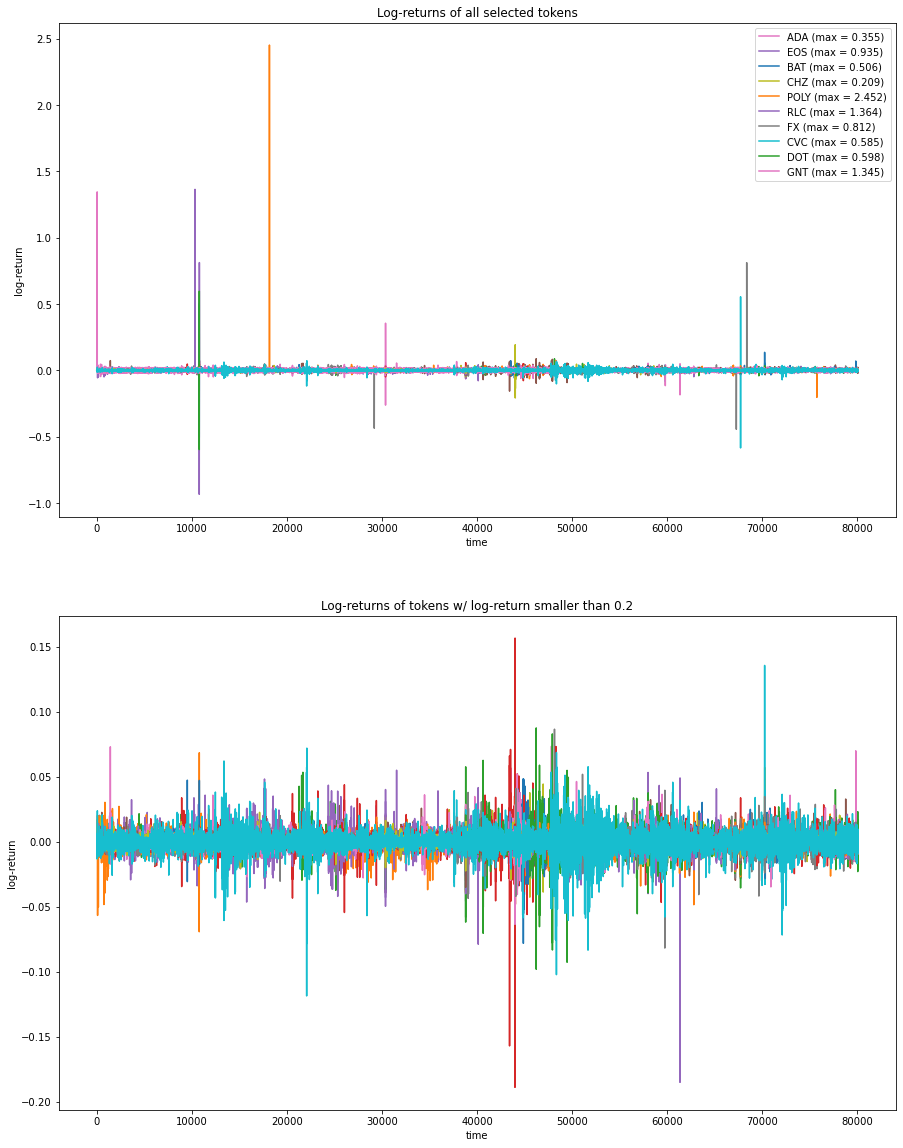

In [ ]:
# plot the log-returns of all tokens w/ threshold to distinguish extremly volatile ones
threshold = 0.2 # threshold to be modified
fig, axs = plt.subplots(2, 1, figsize = (15, 20))

# plot all tokens and record volatile ones based on given threshold
volatile_tokens = []
for col in range(log_return_m.shape[1]):
    prices = log_return_m[:, col]
    max_lr = max(abs(prices)) # max absolute log return of the given token
    if max_lr > threshold:
        axs[0].plot(prices, label = f'{tickers[col]} (max = {round(max_lr, 3)})')
        volatile_tokens.append(tickers[col])
    else:
        axs[0].plot(prices)
        axs[0].set_title('Log-returns of all selected tokens')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('log-return')

# plot tokens excluding the volatile ones
for col in range(log_return_m.shape[1]):
    prices = log_return_m[:, col]
    if tickers[col] in volatile_tokens:
        continue
    else:
        axs[1].plot(prices)
        axs[1].set_title(f'Log-returns of tokens w/ log-return smaller than {threshold}')
axs[1].set_xlabel('time')
axs[1].set_ylabel('log-return')

In [ ]:
# check the volatile tokens
print (f'{len(volatile_tokens)} volatile tokens are subject to scrutinize')
for t in range(len(tickers)):
    if tickers[t] in volatile_tokens:
        print (f'{tickers[t]} @ {t}')

10 volatile tokens are subject to scrutinize
ADA @ 6
EOS @ 14
BAT @ 20
CHZ @ 28
POLY @ 31
RLC @ 34
FX @ 37
CVC @ 39
DOT @ 42
GNT @ 46


## Question to reflect on: do we want to remove some extremly volatile tokens?

Keeping them all for now

## Roughly processed matrix available for further exploration

In [ ]:
# if you run through the script, this one below is the log-return matrix of all selected tokens 
# for correlation calculation and further exploration
# manual work might be needed to double check data quality, especially for the volatile ones
log_return_m

array([[-2.01889454e-04,  4.70686328e-05, -3.21802094e-04, ...,
         0.00000000e+00,  1.47362217e-04, -2.42929149e-03],
       [ 6.47482991e-05,  1.71445572e-04,  5.36279307e-04, ...,
         0.00000000e+00,  0.00000000e+00,  4.50685457e-03],
       [-3.19140630e-04, -3.59733398e-04,  1.07221359e-04, ...,
         0.00000000e+00, -3.09917603e-03, -3.45960910e-04],
       ...,
       [-2.93167085e-04,  7.86014596e-04,  0.00000000e+00, ...,
         7.81555335e-04,  9.72337089e-04, -1.86549763e-04],
       [-2.01263414e-04, -5.00544996e-04,  9.67585949e-04, ...,
         7.80944983e-04,  4.37243430e-04,  5.59544918e-04],
       [-1.37987639e-04, -5.40589255e-04,  0.00000000e+00, ...,
        -8.67754306e-04, -6.31635227e-04,  5.59232003e-04]])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=922ad83b-862b-48ba-b595-658274e50834' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>